In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from numba import njit, jit, int64, float32, prange

## Basics

### Define the game

In [2]:
nb_actions_1 = 2  # TODO make code able to handle nb_actions > 2
nb_actions_2 = 2
#payouts for player 1 and 2 in each state
payouts_1 = np.ones((nb_actions_1, nb_actions_2))
payouts_2 = np.ones((nb_actions_1, nb_actions_2))
payouts_1[0, 0] = 3/4
payouts_2[0, 0] = 3/4
payouts_1[0, 1] = 0
payouts_2[0, 1] = 4/4
payouts_1[1, 0] = 4/4
payouts_2[1, 0] = 0
payouts_1[1, 1] = 1/4
payouts_2[1, 1] = 1/4

@jit#t(int32(int32, int32))
def get_payouts(action_1 : int, action_2 : int):
    # params: actions of both players
    # return: payouts of both players
    # rtype: Vector{Float64}
    return payouts_1[action_1, action_2], payouts_2[action_1, action_2]





### Get actions

In [3]:
@njit
def get_strategy(random_strategy : np.ndarray):
    # params: random strategy
    # return: a realisation of the random strategy
    # rtype: Matrix{Int}
    shape = random_strategy.shape
    strategy = np.zeros((shape[0], shape[1]), dtype=int64)
    for i in prange(shape[0]):
        for j in prange(shape[1]):
            if np.random.rand() < random_strategy[i, j, 0]:
                strategy[i, j] = 0
            else:
                strategy[i, j] = 1
                
    return strategy

def get_action(strategy : np.ndarray, state : np.ndarray):
    # params: stategy and state
    # return: action taken according to strategy in this state
    # rtype: Int
    if len(strategy.shape) == 2:
        return strategy[state[0], state[1]]
    
    if len(strategy.shape) == 3:
        # return: action taken according to a realisation of the random strategy in this state
        return get_strategy(strategy)[state[0], state[1]]
    
    raise("The strategy doesn't have correct dimensions")

@njit
def get_all_strategies():
    # get them as probability of playing action 1, 2
    # return: an array of the 16 pure strategies (as random strategies)
    # rtype: Array{Float64, 4}
    strategies = np.ones((16, 2, 2, 2), dtype=int64)
    for i in range(16):
        strategies[i, 0, 0, 0] = np.floor(i/8)
        strategies[i, 0, 0, 1] = 1 - strategies[i, 0, 0, 0]
        strategies[i, 0, 1, 0] = np.floor((i%8)/4)
        strategies[i, 0, 1, 1] = 1 - strategies[i, 0, 1, 0]
        strategies[i, 1, 0, 0] = np.floor((i%4)/2)
        strategies[i, 1, 0, 1] = 1 - strategies[i, 1, 0, 0]
        strategies[i, 1, 1, 0] = i%2
        strategies[i, 1, 1, 1] = 1 - strategies[i, 1, 1, 0]
    
    return strategies

@njit
def get_strategy_from_mixture(mixture):
    cumsum_probas = np.cumsum(mixture)
    random_val = np.random.rand()
    indexes = cumsum_probas > random_val
    all_strats = get_all_strategies()
    return get_strategy(all_strats[np.argmax(indexes), :, :, :])

### Get values

In [4]:
@njit
def get_value1(state, strategy_1, strategy_2, nb_tries, nb_iterations):
    # params: starting state, two pure strategies
    # return: mean values of the cycle TODO(explain this), starting from state
    # rtype: Vector{Float64}
    new_state = state
    total_payout_1 = 0.
    total_payout_2 = 0.

    for i in range(nb_iterations):
        action_1 = strategy_1[new_state[0], new_state[1]]
        action_2 = strategy_2[new_state[0], new_state[1]]
        new_state = np.array([action_1, action_2])
        payouts = get_payouts(action_1, action_2)
        if i>4:
            total_payout_1 += payouts[0]
            total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4))
    total_payout_2 /= ((nb_iterations-4))
    
    return total_payout_1, total_payout_2

@njit
def get_value2(state, strategy_1, rnd_strat_2, nb_tries, nb_iterations):
    # params: starting state, one pure and one random strategy
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    for t in prange(nb_tries):
        new_state = state.copy()
        
        for i in range(nb_iterations):
            action_1 = strategy_1[new_state[0], new_state[1]]
            action_2 = get_strategy(rnd_strat_2)[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    return total_payout_1, total_payout_2

@njit
def get_value3(state, rnd_strat_1, strategy_2, nb_tries, nb_iterations):
    # params: starting state, one pure and one random strategy
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    
    for t in prange(nb_tries):
        new_state = state.copy()
        for i in range(nb_iterations):
            action_1 = get_strategy(rnd_strat_1)[new_state[0], new_state[1]]
            action_2 = strategy_2[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    
    return total_payout_1, total_payout_2

@njit
def get_value4(state, rnd_strat_1, rnd_strat_2, nb_tries, nb_iterations):
    # params: starting state, two random strategies
    # return: mean value of game after many iterations, starting from state
    # rtype: Vector{Float64}
    total_payout_1 = 0.
    total_payout_2 = 0.
    for t in prange(nb_tries):
        new_state = state.copy()
        for i in range(nb_iterations):
            action_1 = get_strategy(rnd_strat_1)[new_state[0], new_state[1]]
            action_2 = get_strategy(rnd_strat_2)[new_state[0], new_state[1]]
            new_state = np.array([action_1, action_2])
            payouts = get_payouts(action_1, action_2)
            if i>4:
                total_payout_1 += payouts[0]
                total_payout_2 += payouts[1]
    
    total_payout_1 /= ((nb_iterations-4) * nb_tries)
    total_payout_2 /= ((nb_iterations-4) * nb_tries)
    return total_payout_1, total_payout_2

def get_value(state, strategy_1, strategy_2, nb_tries=20, nb_iterations=20):
    state = np.array(state)
    if len(strategy_1.shape) == 2:
        if len(strategy_2.shape) == 2:
            return get_value1(state, strategy_1, strategy_2, nb_tries, nb_iterations)
        if len(strategy_2.shape) == 3:
            return get_value2(state, strategy_1, strategy_2, nb_tries, nb_iterations)
    if len(strategy_1.shape) == 3:
        if len(strategy_2.shape) == 2:
            return get_value3(state, strategy_1, strategy_2, nb_tries, nb_iterations)
        if len(strategy_2.shape) == 3:
            return get_value4(state, strategy_1, strategy_2, nb_tries, nb_iterations)


strategy_1 = np.ones((nb_actions_1, nb_actions_2), dtype=int)
strategy_2 = np.ones((nb_actions_1, nb_actions_2), dtype=int)
strategy_1[0, 0] = 0
strategy_1[0, 1] = 1
strategy_1[1, 0] = 1
strategy_1[1, 1] = 1

strategy_2[0, 0] = 0
strategy_2[0, 1] = 1
strategy_2[1, 0] = 1
strategy_2[1, 1] = 1

# print(get_value([1, 1], strategy_1, strategy_2))

def get_value_in_all_states(strategy_1, strategy_2, nb_tries=20, nb_iterations=20):
    values = np.zeros((nb_actions_1, nb_actions_2, 2))
    for i in range(nb_actions_1):
        for j in range(nb_actions_2):
            value = get_value([i, j], strategy_1, strategy_2, nb_tries, nb_iterations)
            values[i, j, 0] = value[0]
            values[i, j, 1] = value[1]
    return values

print(np.sum(get_value_in_all_states(strategy_1, strategy_2)[:,:,1]))

1.40625


## Algorithms

In [5]:
all_strategies = get_all_strategies()
# print(all_strategies[1])
print('Strategies for player 1')
print('Tit for tat : \n', get_strategy(all_strategies[10])) # Tit for tat
print('Always defect : \n', get_strategy(all_strategies[0])) # Always defect
print('Always cooperate : \n', get_strategy(all_strategies[15])) # Always cooperate
print('Grim trigger : \n', get_strategy(all_strategies[8])) # Grim trigger

print('Strategies for player 2')
print('Tit for tat : \n', get_strategy(all_strategies[10]).T) # Tit for tat
print('Always defect : \n', get_strategy(all_strategies[0]).T) # Always defect
print('Always cooperate : \n', get_strategy(all_strategies[15]).T) # Always cooperate
print('Grim trigger : \n', get_strategy(all_strategies[8]).T) # Grim trigger

Strategies for player 1
Tit for tat : 
 [[0 1]
 [0 1]]
Always defect : 
 [[1 1]
 [1 1]]
Always cooperate : 
 [[0 0]
 [0 0]]
Grim trigger : 
 [[0 1]
 [1 1]]
Strategies for player 2
Tit for tat : 
 [[0 0]
 [1 1]]
Always defect : 
 [[1 1]
 [1 1]]
Always cooperate : 
 [[0 0]
 [0 0]]
Grim trigger : 
 [[0 1]
 [1 1]]


First, we define for all $i$
$$
\tilde{x}_i = \exp(\eta(x_i - \max_{j\in [d]} x_j))
$$
The custom logit for $x\in \mathbb R^d$ is defined as
$$
y_i = \frac{\sum_{k=1}^i\tilde{x}_k}{\sum_{k=1}^d\tilde{x}_k}
$$
The fraction is a normalized cumulative sum.
The selected index is 
$$
\argmax_i\ (\mathbb{I}(y_i > U))_{i\in[d]}
$$
with $U$ a random variable following uniform distribution on $[0,1]$.
So we define the function $L$
$$
L(x) = 
\argmax_i\ (\mathbb{I}(y_i > U))_{i\in[d]}
$$

In [6]:
@njit
def custom_logit(array, pivot):
    exp_arr = np.exp(array - np.max(array))
    cumsum_normed_exp = np.cumsum(exp_arr / np.sum(exp_arr))
    indexes = cumsum_normed_exp > pivot
    return np.argmax(indexes) # works since argmax returns the first highest value

def get_learned_strategy(state_frequencies, id, adv_strategy, previous_means, t, pivot,
                         eta = lambda t : np.sqrt(t)):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: latext strategy of the other player
    #    previous_means:
    #    t: current stage
    # return: a strategy, updated means of all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(16)
    for strategy_idx in prange(16):
        strategy_candidate = get_strategy(all_strategies[strategy_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)
        
        future_reward_per_strategy[strategy_idx] = np.sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / (t+1)
    chosen_strategy_idx = custom_logit((eta(t) * means), pivot)
    strategy_rand = all_strategies[chosen_strategy_idx, :, :, :]
    strategy = get_strategy(strategy_rand)
    #println(strategy_rand)
    return strategy, means, chosen_strategy_idx

def get_learned_strategy_emp(state_frequencies, id, adv_strategy, previous_means, t, pivot,
                         eta = lambda t : np.sqrt(t)):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: empirical mixed strategy of the other player
    #    t: current stage
    # return: a strategy, scores of  all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(16)
    for strategy_idx in prange(16):
        strategy_candidate = get_strategy(all_strategies[strategy_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)

        future_reward_per_strategy[strategy_idx] = np.sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / (t+1)
    chosen_strategy_idx = custom_logit((eta(t) * future_reward_per_strategy), pivot)
    strategy = get_strategy(all_strategies[chosen_strategy_idx, :, :, :])
    return strategy, future_reward_per_strategy, chosen_strategy_idx


def get_learned_strategy_half_memory(state_frequencies, id, adv_strategy, previous_means, t):
    # params:
    #    state_frequencies:
    #    id: equal to 1 if player 1, 2 if player 2
    #    adv_strategy: latext strategy of the other player
    #    previous_means:
    #    t: current stage
    # return: a strategy, updated means of all pure strategies
    # rtype: (Matrix{Int}, Vector{Float64})
    future_reward_per_strategy = np.zeros(4)
    strategies = np.zeros(4)
    for strategy_idx in range(4):
        if id==0:
            strategies = [1, 6, 11, 16]
        else:
            strategies = [1, 4, 13, 16]

        s_idx = strategies[strategy_idx]
        strategy_candidate = get_strategy(all_strategies[s_idx, :, :, :])
        if id==0:
            all_values = get_value_in_all_states(strategy_candidate, adv_strategy)
        else:
            all_values = get_value_in_all_states(adv_strategy, strategy_candidate)
            
        future_reward_per_strategy[strategy_idx] = sum(all_values[:, :, id] * state_frequencies)
    
    means = previous_means + (future_reward_per_strategy - previous_means) / t
    chosen_strategy_idx = strategies[custom_logit((np.sqrt(t) * means))]
    strategy_rand = all_strategies[chosen_strategy_idx, :, :, :]
    strategy = get_strategy(strategy_rand)
    #println(chosen_strategy_idx, strategy)
    return strategy, means



## Some simulations

### Preliminaries

In [7]:
get_value_in_all_states(
    strategy_1,
    0.4 * all_strategies[12, :, :, :] + 0.6 * all_strategies[14, :, :, :])

array([[[0.703125  , 0.703125  ],
        [0.26015625, 0.22578125]],

       [[0.253125  , 0.228125  ],
        [0.234375  , 0.234375  ]]])

In [8]:
all_values = np.zeros((16, 16, 4))
for strat_rnd in range(16):
    for strat_rnd_2 in range(16):
        #println(strat_rnd)
        #println(get_strategy(all_strat[strat_rnd, :, :, :]))
        for i in range(2):
            all_values[strat_rnd, strat_rnd_2, i] = get_value_in_all_states(
                get_strategy(all_strategies[strat_rnd, :, :, :]),
                get_strategy(all_strategies[strat_rnd_2, :, :, :]))[0, i, 0]
        
        for i in range(2):
            all_values[strat_rnd, strat_rnd_2, i+2] = get_value_in_all_states(
                get_strategy(all_strategies[strat_rnd, :, :, :]),
                get_strategy(all_strategies[strat_rnd_2, :, :, :]))[1, i, 0]
            
is_good_strategy = np.zeros((16, 16, 4))
strat_good = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        for s in range(4):
            is_good_strategy[i, j, s] = (
                np.max(all_values[:, j, s]) == all_values[i, j, s])
        strat_good[i, j] = np.prod(is_good_strategy[i, j, :])
        
value_matrix = np.sum(all_values[:, :, :], axis = 2)#round(sum(all_values[:, :, :],dims = 3), digits = 1)
print(strat_good)
print(value_matrix)
print(np.prod(value_matrix[:, :] - value_matrix[10,:] >= 0, axis=0))
print(sum(strat_good))  # number of good strategies for each j

[[1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]]
[[0.9375   2.390625 1.640625 3.75     0.9375   2.34375  2.34375  3.75
  0.9375   2.34375  2.34375  3.75     0.9375   2.296875 3.046875 3.75    ]
 [0.453125 1.90625  1.28125  2.359375 

In [9]:
#find equilibrium : i is best strategy against j and j is best against i
is_eq = strat_good * strat_good.T
print(is_eq)
print(all_values[:, :, 2] * is_eq)

[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.234375 0.       0.9375   0.       0.       0.       0.       0.
  0.       0.       0.9375   0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.

In [10]:
def render_results(means1, means2, state_appearances, all_payouts, all_states, strategy_history, 
                   best_reward = 3, *args, **kwargs):
    # plt.plot(np.cumsum(all_payouts[:, 0]), label='player 0')
    # plt.plot(np.cumsum(all_payouts[:, 1]), label='player 1')
    # plt.title('Cummulative rewards')
    # plt.legend()
    # plt.show()
    
    csum1 = np.cumsum(best_reward - all_payouts[:,:,0], axis = 1)
    csum2 = np.cumsum(best_reward - all_payouts[:,:,1], axis = 1)
    
    mean_1 = np.mean(csum1, axis=0)
    mean_2 = np.mean(csum2, axis=0)
    
    std_1 = np.std(csum1, axis=0)
    std_2 = np.std(csum2, axis=0)
    
    min1 = np.amin(csum1, axis=0)
    min2 = np.amin(csum2, axis=0)
    
    max1 = np.amax(csum1, axis=0)
    max2 = np.amax(csum2, axis=0)
    
    median1 = np.median(csum1, axis=0)
    median2 = np.median(csum2, axis=0)

    
    # fig, ax = plt.subplots(2, 1)
    # plt.plot(min1, linestyle=':', label='min regret', color='black')
    # plt.plot(mean_1, label='mean regret')
    # plt.plot(median1, label='median regret', linestyle='--', color='black')
    # plt.plot(max1, label='max regret', linestyle='-.', color='black')
    # plt.fill_between(range(len(mean_1)), mean_1 - 2*std_1, mean_1 + 2*std_1, alpha=0.3, label="mean $\pm 2\sigma$")
    # plt.fill_between(range(len(mean_1)), mean_1 - std_1, mean_1 + std_1, alpha=0.7, label="mean $\pm \sigma$")
    # plt.title('Cumulative "regret" player 0')
    # plt.xlabel("Time $t$")
    # plt.legend()
    # plt.show()
    
    # plt.plot(min2, linestyle=':', label='min regret', color='black')
    # plt.plot(mean_2, label='mean regret')
    # plt.plot(median2, label='median regret', linestyle='--', color='black')
    # plt.plot(max2, label='max regret', linestyle='-.', color='black')
    # plt.fill_between(range(len(mean_2)), mean_2 - 2*std_2, mean_2 + 2*std_2, alpha=0.3, label="mean $\pm 2\sigma$")
    # plt.fill_between(range(len(mean_2)), mean_2 - std_2, mean_2 + std_2, alpha=0.7, label="mean $\pm \sigma$")
    # # plt.plot(15*np.sqrt(np.arange(len(mean_1))), label='$15\sqrt{t}$')
    # plt.title('Cumulative "regret" player 1')
    # plt.xlabel("Time $t$")
    # plt.legend()
    # plt.legend()
    # plt.show()
    
    # plot:
    fig, ax = plt.subplots(1,2)
    sample_strategy = strategy_history[np.random.choice(len(strategy_history), min(len(strategy_history), 25), replace=False)]
    a = 0.1
    for i in range(len(sample_strategy)):
        ax[0].scatter(np.arange(sample_strategy.shape[1]), sample_strategy[i, :, 0].reshape(-1), alpha=a/len(sample_strategy), color='gray')
        ax[1].scatter(np.arange(sample_strategy.shape[1]), sample_strategy[i, :, 1].reshape(-1), alpha=a/len(sample_strategy), color='gray')
    # ax[0].legend()
    # ax[1].legend()
    ax[0].set_title("Strategy usage player 0")
    ax[1].set_title("Strategy usage player 1")
    ax[0].set_xlabel("Time $t$")
    ax[1].set_xlabel("Time $t$")
    
    ax[0].set_ylabel("Strategy played")

    plt.show()
    
    mean_1 = np.mean(all_payouts[:, :, 0], axis=0)
    mean_2 = np.mean(all_payouts[:, :, 1], axis=0)
    
    std_1 = np.std(all_payouts[:, :, 0], axis=0)
    std_2 = np.std(all_payouts[:, :, 1], axis=0)
    
    payout_mean_1 = np.cumsum(mean_1) / np.cumsum(np.ones(all_payouts.shape[1]))
    payout_mean_2 = np.cumsum(mean_2) / np.cumsum(np.ones(all_payouts.shape[1]))
    plt.plot(payout_mean_1, label='player 0')
    plt.fill_between(range(len(mean_1)), payout_mean_1 - 2*std_1, payout_mean_1 + 2*std_1, alpha=0.3)
    plt.plot(payout_mean_2, label='player 1')
    plt.fill_between(range(len(mean_2)), payout_mean_2 - 2*std_2, payout_mean_2 + 2*std_2, alpha=0.3)
    plt.title('Mean rewards')
    plt.legend()
    plt.show()
    
    # plt.plot(all_payouts[:, 0], label='player 0')
    # plt.plot(all_payouts[:, 1], label='player 1')
    # plt.title('Rewards per iteration')
    # plt.legend()
    # plt.show()
    
    # plt.imshow(state_apearences)#, interpolation='nearest')
    ax = sns.heatmap(state_appearances/np.sum(state_appearances), cmap='crest', linewidth=0.5, annot=True)
    plt.title('Appearance rate per state')
    plt.show()

In [11]:
def save_results(results, name = None):
    try:
        import pickle
        if name is None:
            import datetime
            name = "simulations/"+str(datetime.datetime.now().strftime("%H:%M:%S_%d-%m-%Y"))+".pickle"
        with open(name, "wb") as f:
            pickle.dump(results, f)
        print("Results saved with sucess !")
    except Exception as e:
        print("Something went wrong :")
        print(e)
        import os
        os.remove(name)
    

### Simulation 1
We begin with "always defect" strategies for both players

In [12]:
def simulation(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = None,
    rng_state = None,
    eta = lambda t : np.sqrt(t),
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
    
    # print('RNG seed : ', rng_state[1][0])
    
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    
    means1 = np.zeros(16)
    means2 = np.zeros(16)
    #means1 = zeros(4)
    #means2 = zeros(4)
    # payout_mean_1 = 0
    # payout_mean_2 = 0
    
    all_payouts = np.zeros((nb_games, game_length, 2))
    strategy_history = np.zeros((nb_games, game_length, 2))
    
    for g in (range(nb_games)):
        
        if initial_state is None:
            initial_state = np.random.randint(2, size=2)
            
        state = initial_state.copy()
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        # random_strategy_2[1, 1, 1] = 1
        if strategy_2 is None:
            idx2 = np.random.randint(len(all_strategies))
            strategy_2 = get_strategy(all_strategies[idx2, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            idx1 = np.random.randint(len(all_strategies))
            strategy_1 = get_strategy(all_strategies[idx1, :, :, :])
            fixed_strat1 = False
            
        # print(idx1, idx2)
        # rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        # rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            
            if not fixed_strat1:
                strategy_history[g, i, 0] = idx1
            if not fixed_strat2:
                strategy_history[g, i, 1] = idx2
            
            all_payouts[g, i, 0] = payouts[0]
            all_payouts[g, i, 1] = payouts[1]
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / sum(state_appearances)
            state_frequencies = np.ones((2, 2)) / 4
            if not fixed_strat1:
                pivot = np.random.rand()
                strategy_1, means1, idx1 = get_learned_strategy(#_half_memory(
                    state_frequencies, 0, strategy_2, means1, i, pivot, eta)
                
            #strategy_1, means1 = get_learned_strategy_emp(
            #    state_frequencies, 1, rnd_strategy_2_emp, i)
            if not fixed_strat2:
                pivot = np.random.rand()
                strategy_2, means2, idx2 = get_learned_strategy(#_half_memory(
                    state_frequencies, 1, strategy_1, means2, i, pivot, eta)
                
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        # payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        # payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
    return means1, means2, state_appearances, all_payouts, all_states, strategy_history, rng_state


Here, we extract some failures and store them

100%|██████████| 1000/1000 [00:00<00:00, 3112.60it/s]


failure at  1
treason_rate :  0.5224775224775224


100%|██████████| 1000/1000 [00:00<00:00, 3136.29it/s]


failure at  2
treason_rate :  0.5004995004995005


100%|██████████| 1000/1000 [00:00<00:00, 3113.21it/s]


failure at  3
treason_rate :  0.5034965034965035


100%|██████████| 1000/1000 [00:00<00:00, 3127.18it/s]


failure at  4
treason_rate :  0.5104895104895105


100%|██████████| 1000/1000 [00:00<00:00, 3080.23it/s]


failure at  5
treason_rate :  0.5004995004995005


100%|██████████| 1000/1000 [00:00<00:00, 3039.35it/s]


failure at  6
treason_rate :  0.5074925074925075


100%|██████████| 1000/1000 [00:00<00:00, 3017.81it/s]


failure at  7
treason_rate :  0.5414585414585414


100%|██████████| 1000/1000 [00:00<00:00, 3098.61it/s]


failure at  8
treason_rate :  0.5144855144855145


100%|██████████| 1000/1000 [00:00<00:00, 3092.00it/s]


failure at  9
treason_rate :  0.5434565434565435


100%|██████████| 1000/1000 [00:00<00:00, 3015.38it/s]


failure at  10
treason_rate :  0.5214785214785215


100%|██████████| 1000/1000 [00:00<00:00, 2981.26it/s]


failure at  11
treason_rate :  0.5234765234765235


100%|██████████| 1000/1000 [00:00<00:00, 3041.92it/s]


failure at  12
treason_rate :  0.5254745254745254


100%|██████████| 1000/1000 [00:00<00:00, 3072.65it/s]


failure at  13
treason_rate :  0.5134865134865135


100%|██████████| 1000/1000 [00:00<00:00, 3102.88it/s]


failure at  14
treason_rate :  0.5404595404595405


100%|██████████| 1000/1000 [00:00<00:00, 3095.93it/s]


failure at  15
treason_rate :  0.5504495504495505


100%|██████████| 1000/1000 [00:00<00:00, 2927.04it/s]


failure at  16
treason_rate :  0.5254745254745254


100%|██████████| 1000/1000 [00:00<00:00, 3053.55it/s]


failure at  17
treason_rate :  0.5234765234765235


100%|██████████| 1000/1000 [00:00<00:00, 3105.19it/s]


failure at  18
treason_rate :  0.5224775224775224


100%|██████████| 1000/1000 [00:00<00:00, 3117.64it/s]


failure at  19
treason_rate :  0.5134865134865135


100%|██████████| 1000/1000 [00:00<00:00, 3123.18it/s]


failure at  20
treason_rate :  0.5124875124875125


100%|██████████| 1000/1000 [00:00<00:00, 3126.25it/s]


failure at  21
treason_rate :  0.5254745254745254


100%|██████████| 1000/1000 [00:00<00:00, 3111.06it/s]


failure at  22
treason_rate :  0.5164835164835165


100%|██████████| 1000/1000 [00:00<00:00, 3016.17it/s]


failure at  23
treason_rate :  0.5304695304695305


100%|██████████| 1000/1000 [00:00<00:00, 3099.14it/s]


failure at  24
treason_rate :  0.5254745254745254


100%|██████████| 1000/1000 [00:00<00:00, 3086.78it/s]


failure at  25
treason_rate :  0.5054945054945055


100%|██████████| 1000/1000 [00:00<00:00, 3103.90it/s]


failure at  26
treason_rate :  0.5334665334665335


100%|██████████| 1000/1000 [00:00<00:00, 3111.13it/s]


failure at  27
treason_rate :  0.5104895104895105


100%|██████████| 1000/1000 [00:00<00:00, 3106.76it/s]


failure at  28
treason_rate :  0.5094905094905094


100%|██████████| 1000/1000 [00:00<00:00, 3102.63it/s]


failure at  29
treason_rate :  0.5294705294705294


100%|██████████| 1000/1000 [00:00<00:00, 3096.64it/s]


failure at  30
treason_rate :  0.5324675324675324


100%|██████████| 1000/1000 [00:00<00:00, 3045.09it/s]


failure at  31
treason_rate :  0.5284715284715285


100%|██████████| 1000/1000 [00:00<00:00, 3035.13it/s]


failure at  32
treason_rate :  0.5124875124875125


100%|██████████| 1000/1000 [00:00<00:00, 3079.65it/s]


failure at  33
treason_rate :  0.5014985014985015


100%|██████████| 1000/1000 [00:00<00:00, 3107.67it/s]


failure at  34
treason_rate :  0.5334665334665335


100%|██████████| 1000/1000 [00:00<00:00, 3114.76it/s]


failure at  35
treason_rate :  0.5184815184815185


100%|██████████| 1000/1000 [00:00<00:00, 3116.01it/s]


failure at  36
treason_rate :  0.5374625374625375


100%|██████████| 1000/1000 [00:00<00:00, 3102.60it/s]


failure at  37
treason_rate :  0.5084915084915085


100%|██████████| 1000/1000 [00:00<00:00, 3133.51it/s]


failure at  38
treason_rate :  0.5454545454545454


100%|██████████| 1000/1000 [00:00<00:00, 3115.38it/s]


failure at  39
treason_rate :  0.5024975024975025


100%|██████████| 1000/1000 [00:00<00:00, 3118.31it/s]


failure at  40
treason_rate :  0.5214785214785215


100%|██████████| 1000/1000 [00:00<00:00, 3069.47it/s]


failure at  41
treason_rate :  0.5644355644355644


100%|██████████| 1000/1000 [00:00<00:00, 3073.10it/s]


failure at  42
treason_rate :  0.5354645354645354


100%|██████████| 1000/1000 [00:00<00:00, 3066.88it/s]


failure at  43
treason_rate :  0.5224775224775224


100%|██████████| 1000/1000 [00:00<00:00, 2991.40it/s]


failure at  44
treason_rate :  0.5554445554445554


100%|██████████| 1000/1000 [00:00<00:00, 3064.04it/s]


failure at  45
treason_rate :  0.5184815184815185


100%|██████████| 1000/1000 [00:00<00:00, 3078.20it/s]


failure at  46
treason_rate :  0.5194805194805194


100%|██████████| 1000/1000 [00:00<00:00, 3137.39it/s]


failure at  47
treason_rate :  0.5184815184815185


100%|██████████| 1000/1000 [00:00<00:00, 3090.18it/s]


failure at  48
treason_rate :  0.5244755244755245


100%|██████████| 1000/1000 [00:00<00:00, 3046.73it/s]


failure at  49
treason_rate :  0.5454545454545454


100%|██████████| 1000/1000 [00:00<00:00, 3080.94it/s]


failure at  50
treason_rate :  0.5014985014985015


100%|██████████| 1000/1000 [00:00<00:00, 3111.57it/s]


failure at  51
treason_rate :  0.5034965034965035


100%|██████████| 1000/1000 [00:00<00:00, 3071.15it/s]


failure at  52
treason_rate :  0.5214785214785215


100%|██████████| 1000/1000 [00:00<00:00, 2991.40it/s]


failure at  53
treason_rate :  0.5684315684315684


100%|██████████| 1000/1000 [00:00<00:00, 3070.99it/s]


failure at  54
treason_rate :  0.5024975024975025


100%|██████████| 1000/1000 [00:00<00:00, 3025.04it/s]


failure at  55
treason_rate :  0.5584415584415584


100%|██████████| 1000/1000 [00:00<00:00, 3135.09it/s]


failure at  56
treason_rate :  0.5434565434565435


100%|██████████| 1000/1000 [00:00<00:00, 3006.07it/s]


failure at  57
treason_rate :  0.5584415584415584


100%|██████████| 1000/1000 [00:00<00:00, 2534.67it/s]


failure at  58
treason_rate :  0.5144855144855145


100%|██████████| 1000/1000 [00:00<00:00, 3033.74it/s]


failure at  59
treason_rate :  0.5304695304695305


100%|██████████| 1000/1000 [00:00<00:00, 3146.18it/s]


failure at  60
treason_rate :  0.5304695304695305


100%|██████████| 1000/1000 [00:00<00:00, 3116.83it/s]


failure at  61
treason_rate :  0.5034965034965035


100%|██████████| 1000/1000 [00:00<00:00, 3139.63it/s]


failure at  62
treason_rate :  0.5004995004995005


100%|██████████| 1000/1000 [00:00<00:00, 3103.22it/s]


failure at  63
treason_rate :  0.5434565434565435


100%|██████████| 1000/1000 [00:00<00:00, 2997.68it/s]


failure at  64
treason_rate :  0.5264735264735265


100%|██████████| 1000/1000 [00:00<00:00, 3076.09it/s]


failure at  65
treason_rate :  0.5124875124875125


100%|██████████| 1000/1000 [00:00<00:00, 3022.15it/s]


failure at  66
treason_rate :  0.5124875124875125


100%|██████████| 1000/1000 [00:00<00:00, 3121.14it/s]


failure at  67
treason_rate :  0.5234765234765235


100%|██████████| 1000/1000 [00:00<00:00, 3079.94it/s]


failure at  68
treason_rate :  0.5474525474525475


100%|██████████| 1000/1000 [00:00<00:00, 3121.33it/s]


failure at  69
treason_rate :  0.5094905094905094


100%|██████████| 1000/1000 [00:00<00:00, 3106.90it/s]


failure at  70
treason_rate :  0.5294705294705294


100%|██████████| 1000/1000 [00:00<00:00, 3156.28it/s]


failure at  71
treason_rate :  0.5454545454545454


100%|██████████| 1000/1000 [00:00<00:00, 3128.37it/s]

failure at  72
treason_rate :  0.5184815184815185


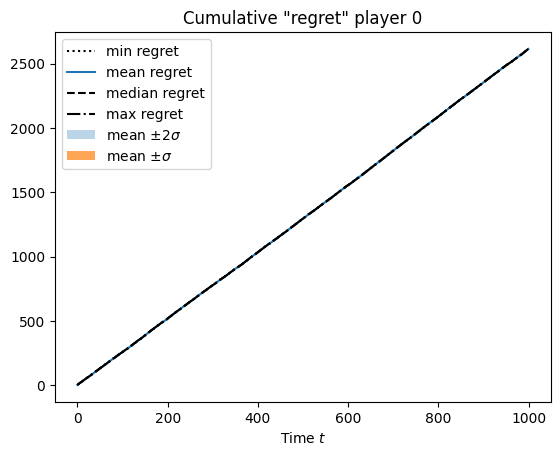

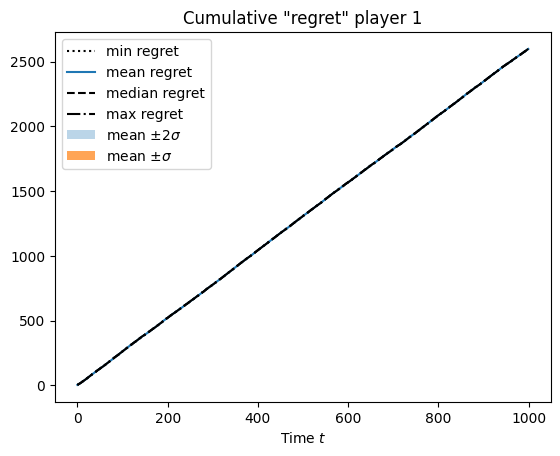

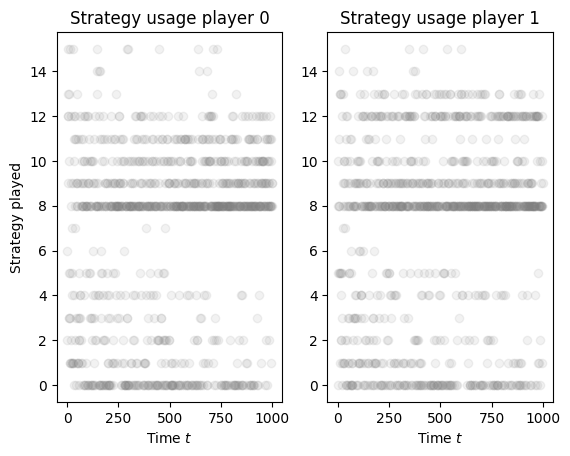

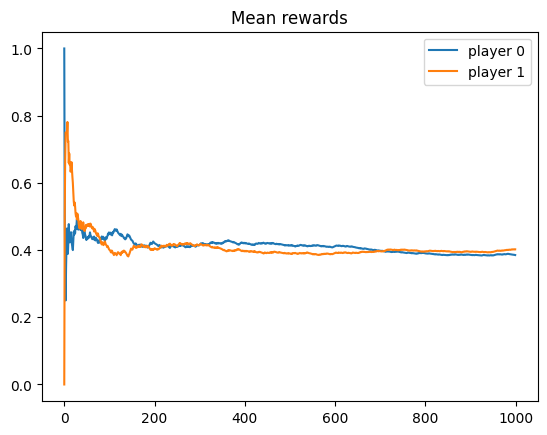

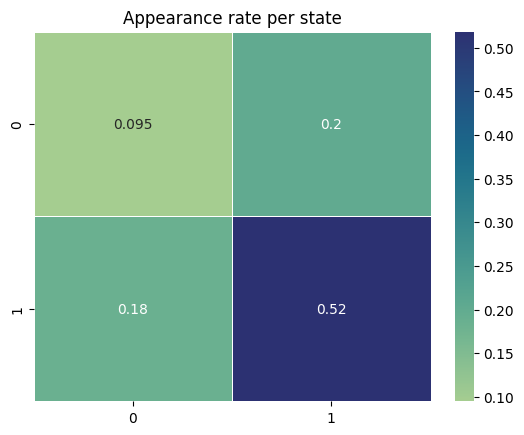

In [39]:
import pickle
i = 1
for k in range(100):
    *results, rng_state = simulation(game_length=1000)
    treason_rate = results[2][1,1]/np.sum(results[2])
    if treason_rate >= 0.5:
        print('failure at ', k)
        print('treason_rate : ', treason_rate)
        with open(f'./failures/failure_{i}.pickle', 'wb') as f:
            pickle.dump(rng_state, f)
        i += 1
        
render_results(*results)

In [14]:
import pickle
with open('./failures/failure_1.pickle', 'rb') as f:
    rng_s = pickle.load(f)

It works with longer game lengths

In [15]:
get_strategy(all_strategies[11])

array([[0, 1],
       [0, 0]])

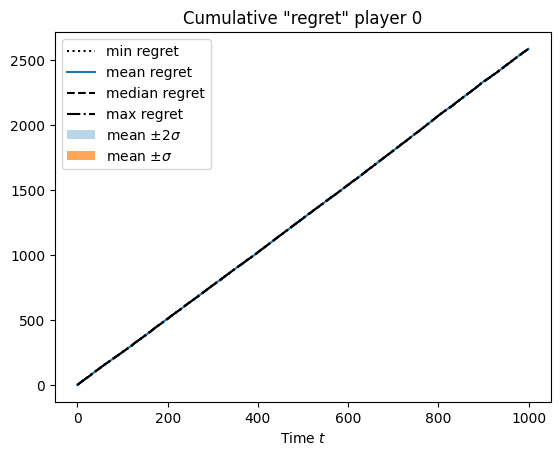

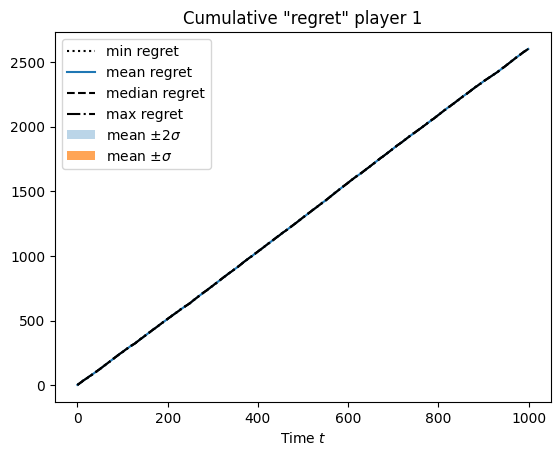

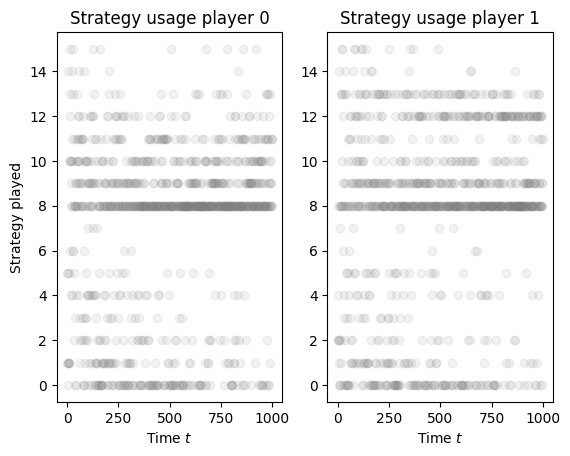

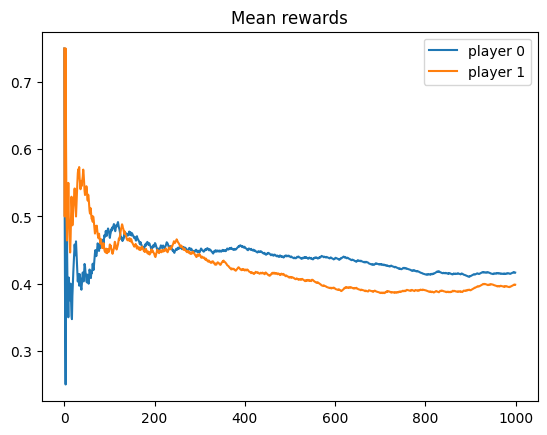

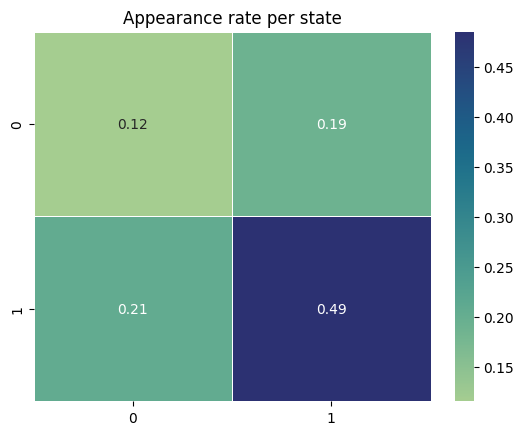

In [16]:
render_results(*results)

100%|██████████| 5000/5000 [00:14<00:00, 336.26it/s]


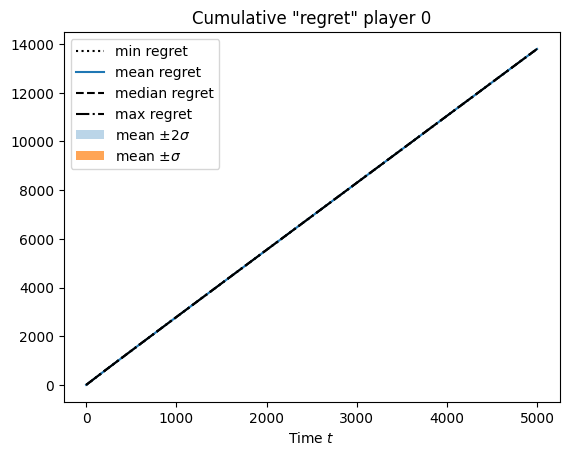

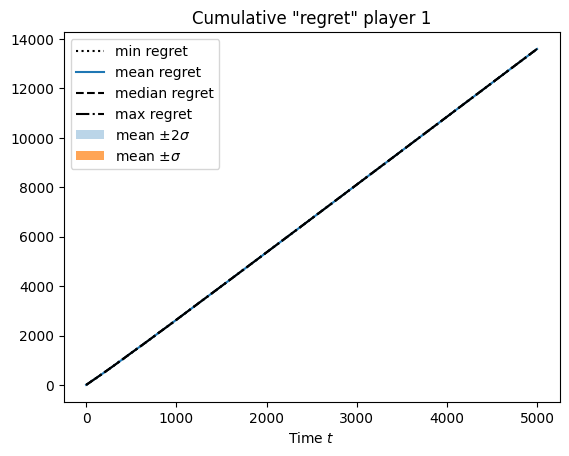

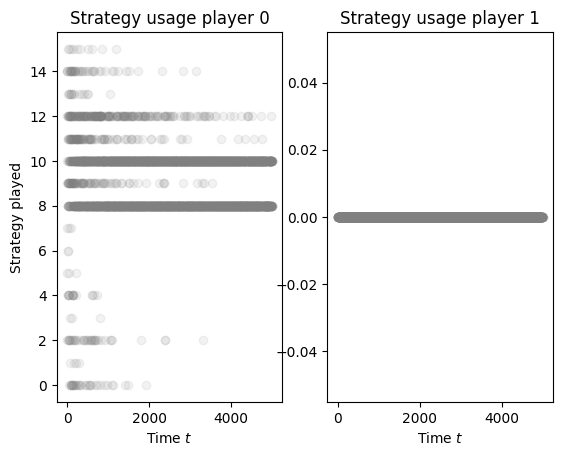

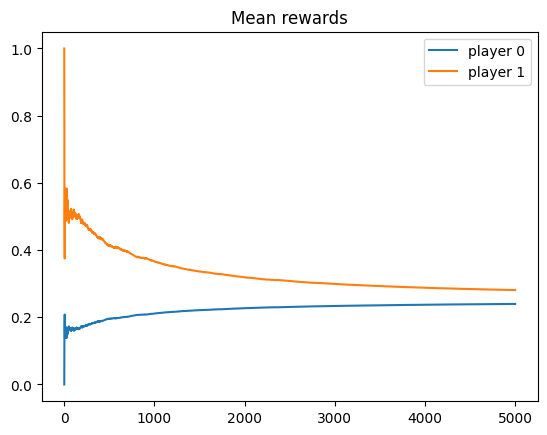

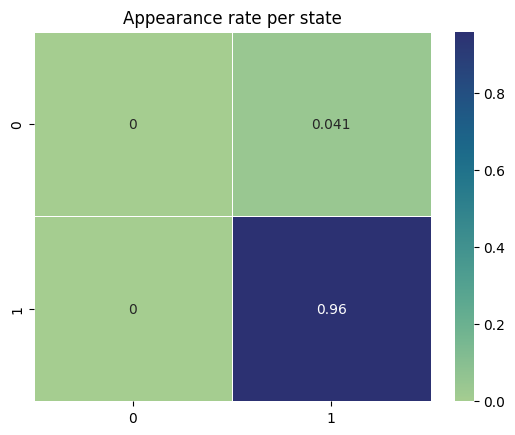

In [17]:
*results, rng_st = simulation(game_length=5_000, strategy_2=all_strategies[8])
render_results(*results)

The $\eta_t = t$ provides a fast convergeance rate !

100%|██████████| 5000/5000 [00:01<00:00, 3179.39it/s]


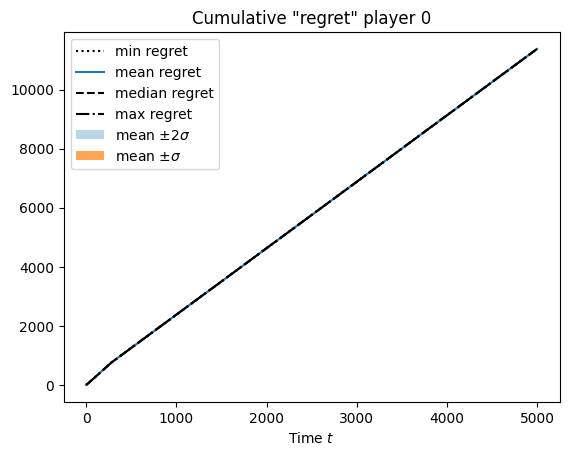

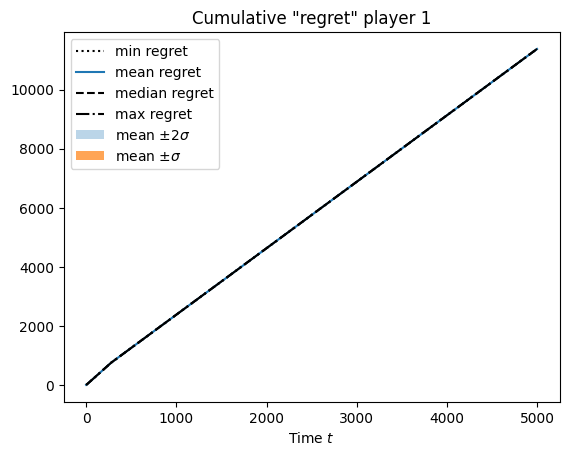

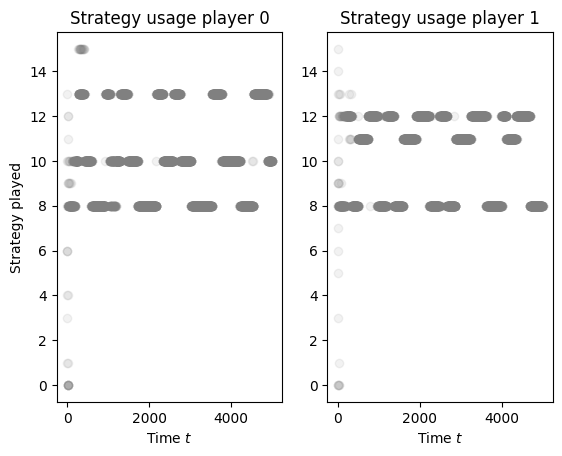

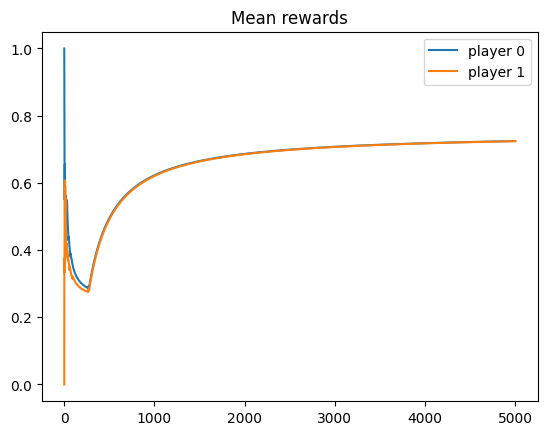

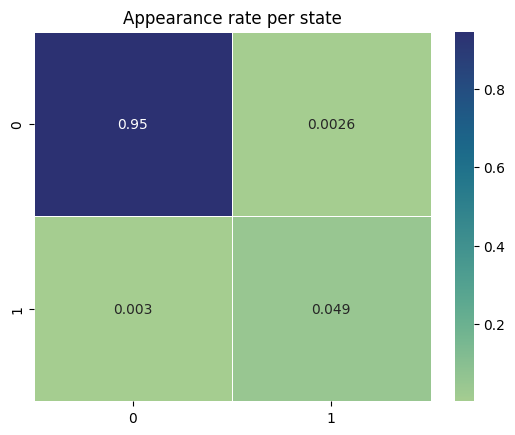

In [18]:
*results, rng_st = simulation(game_length=5_000, rng_state=rng_s, eta=lambda t : t)
render_results(*results)

### Simulation 2 (against tit for tat)

100%|██████████| 1000/1000 [00:00<00:00, 4912.65it/s]


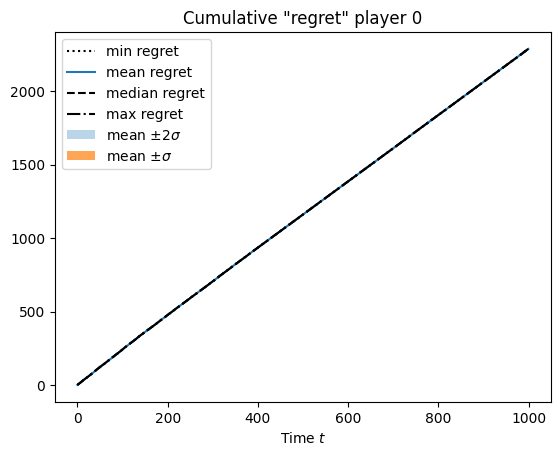

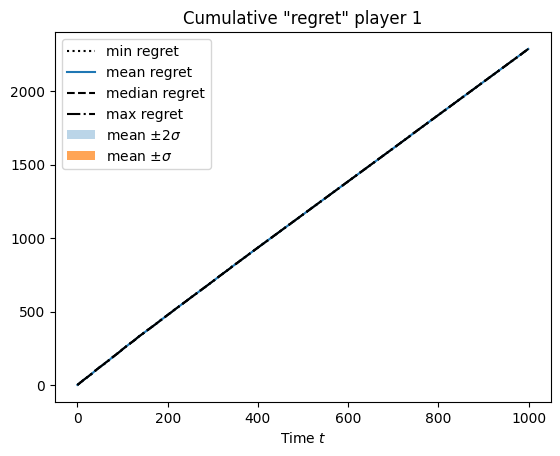

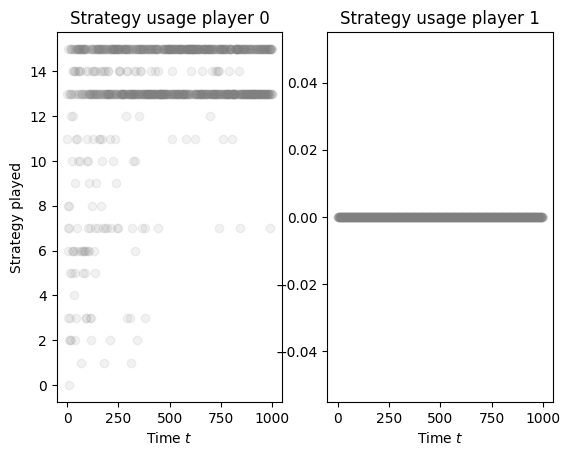

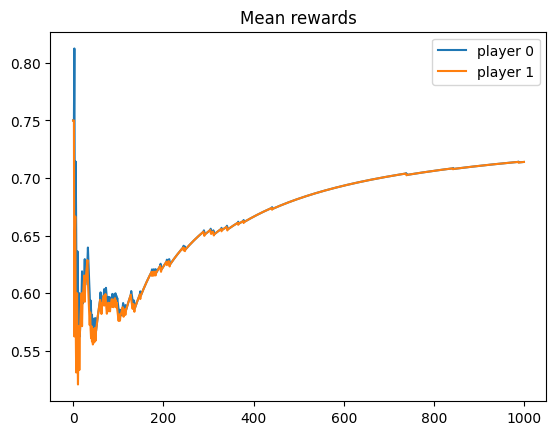

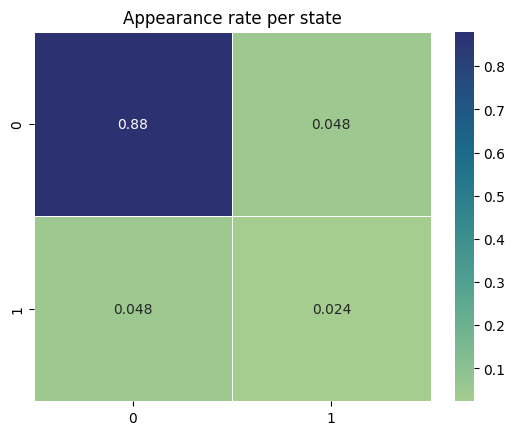

In [19]:
*results2, _ = simulation(strategy_2= get_strategy(all_strategies[12]))
render_results(*results2)

100%|██████████| 1000/1000 [00:00<00:00, 5873.03it/s]


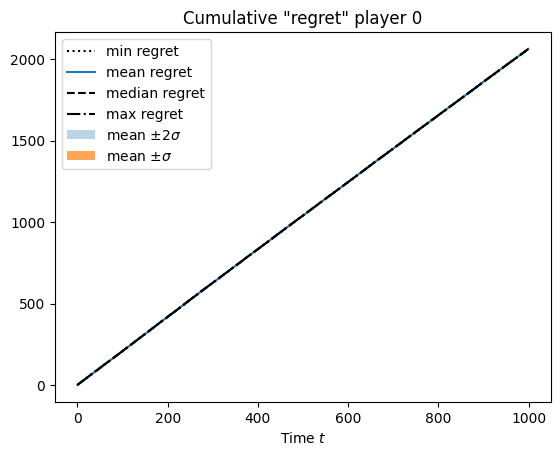

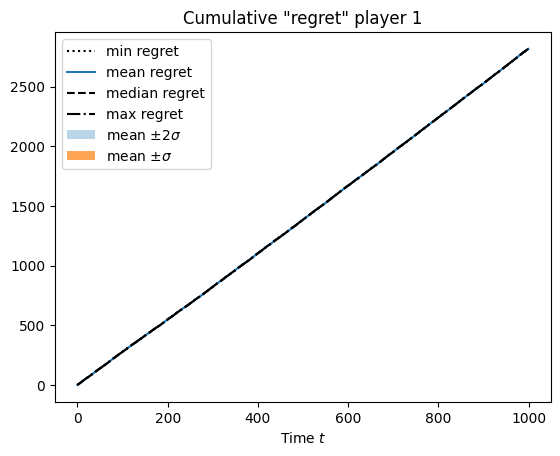

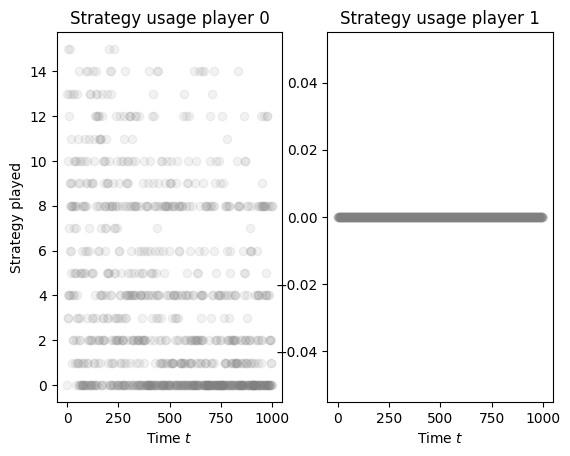

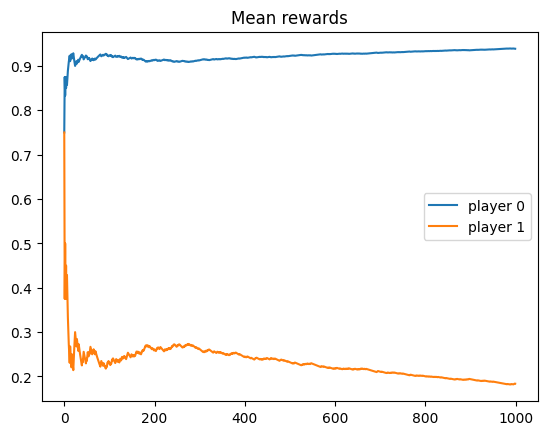

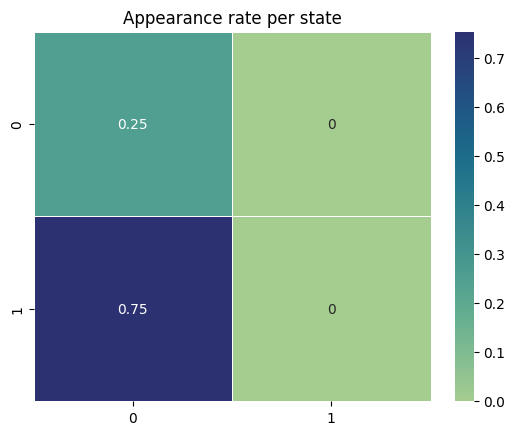

In [20]:
*results3, _ = simulation(strategy_2= get_strategy(all_strategies[10]), initial_state=[0,0])
render_results(*results3)

100%|██████████| 1000/1000 [00:00<00:00, 5779.65it/s]


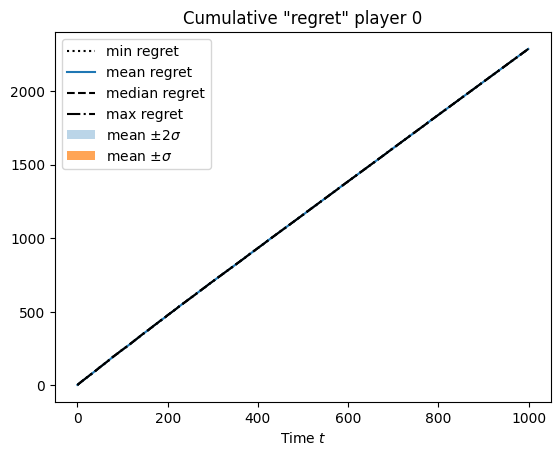

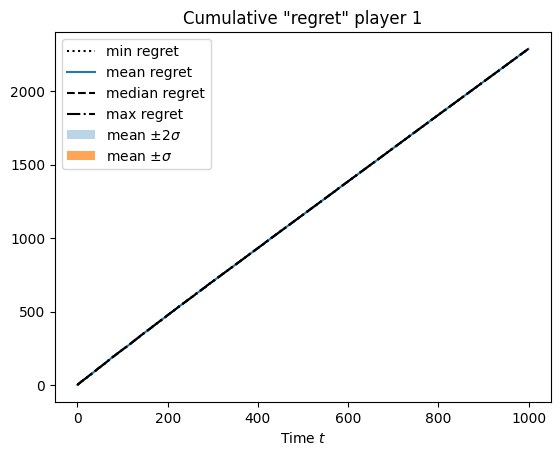

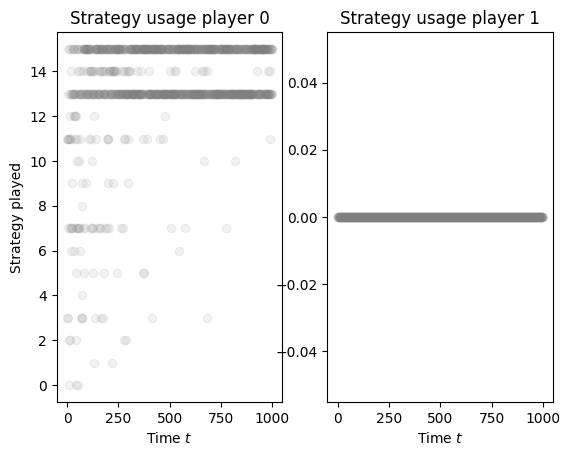

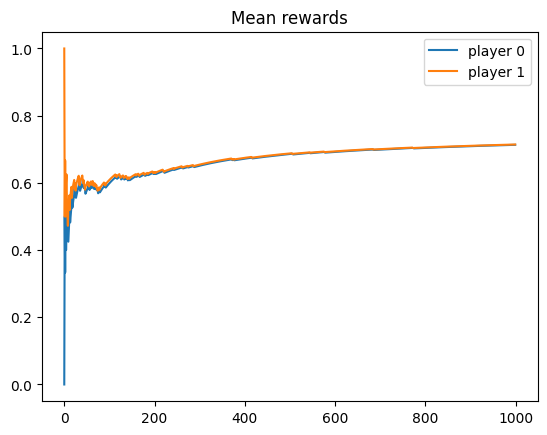

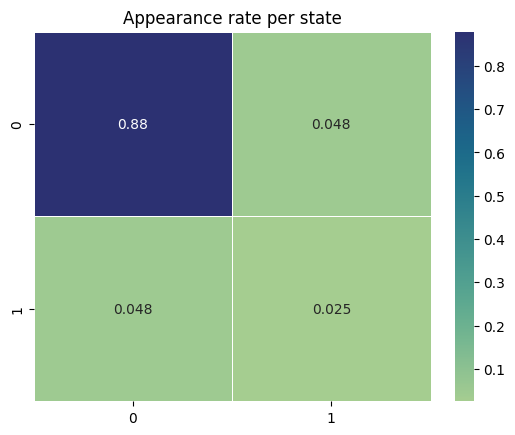

In [21]:
*results3, _ = simulation(strategy_2= get_strategy(all_strategies[12]), initial_state=[1,0])
render_results(*results3)

## Problem
In the algorithm, we assume that we know the other player's strategy which is not the case in the real life. A natural choice is to estimate the adversary's strategy.

### Simple estimation updated every step

In [22]:
def simulation_w_estimation(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = None,
    rng_state = None,
    eta=lambda t : np.sqrt(t),
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
        
    if initial_state is None:
        initial_state = np.random.randint(2, size=2)
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    

    #means1 = zeros(4)
    #means2 = zeros(4)
    payout_mean_1 = 0
    payout_mean_2 = 0
    for _ in range(nb_games):
        state = initial_state.copy()
        
        state_frequencies = np.ones((2, 2)) / 4
        action_state = np.zeros((2, 2, 2, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
    
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        if strategy_2 is None:
            idx1 = np.random.randint(16)
            strategy_2 = get_strategy(all_strategies[idx1, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            idx2 = np.random.randint(16)
            strategy_1 = get_strategy(all_strategies[idx2, :, :, :])
            fixed_strat1 = False
            
        rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_payouts = np.zeros((game_length, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            all_payouts[i, 0] = payouts[0]
            all_payouts[i, 1] = payouts[1]
            action_state[0, state[0], state[1], action_1] += 1
            action_state[1, state[0], state[1], action_2] += 1
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / np.sum(state_appearances)
            if not fixed_strat1:
                pivot = np.random.rand()
                strategy_1, means1 = get_learned_strategy(
                    state_frequencies, 0, rnd_strategy_2_emp, means1, i, pivot)
                
            if not fixed_strat2:
                pivot = np.random.rand()
                strategy_2, means2 = get_learned_strategy(
                   state_frequencies, 1, rnd_strategy_1_emp, means2, i, pivot)
            #strategy_2 = get_strategy(random_strategy_2)
            # full info on the strategies
            #for a=1:2
            #    for b=1:2
            #        rnd_strategy_1_emp[a, b, 1] = (
            #            rnd_strategy_1_emp[a, b, 1]
            #            + (1*(strategy_1[a, b] == 1) - rnd_strategy_1_emp[a,b,1])/(i+1)
            #        )
            #        rnd_strategy_2_emp[a, b, 1] = (
            #            rnd_strategy_2_emp[a, b, 1]
            #            + (1*(strategy_2[a, b] == 1) - rnd_strategy_2_emp[a,b,1])/(i+1)
            #        )
            #    end
            #end
            
            # bandit info
            rnd_strategy_1_emp[state[0], state[1], 0] = (
                action_state[0, state[0], state[1], 0] / np.sum(action_state[0, state[0], state[1]])
                # rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 0) - rnd_strategy_1_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_1_emp[state[0], state[1], 1] = (
                1-rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 1) - rnd_strategy_1_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            
            rnd_strategy_2_emp[state[0], state[1], 0] = (
                action_state[1, state[0], state[1], 0] / np.sum(action_state[1, state[0], state[1]])
                # + (1*(action_2 == 0) - rnd_strategy_2_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_2_emp[state[0], state[1], 1] = (
                1 - rnd_strategy_2_emp[state[0], state[1], 0]
                # rnd_strategy_2_emp[state[0], state[1], 1]
                # + (1*(action_2 == 1) - rnd_strategy_2_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
        return means1, means2, state_appearances, all_payouts, all_states, rng_state


### $\tau$-discounted estimation, update the strategy every $K$ steps

In [23]:
def simulation_w_estimation_K(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = None,
    rng_state = None,
    eta = lambda t : np.sqrt(t),
    K = 150,
    tau = .9,
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
        
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    

    #means1 = zeros(4)
    #means2 = zeros(4)
    payout_mean_1 = 0
    payout_mean_2 = 0
    
    strategy_history = np.zeros((nb_games, game_length, 2))
    all_payouts = np.zeros((nb_games, game_length, 2))
    
    for g in range(nb_games):
        print(f"‘{g+1}/{nb_games}")
        
        if initial_state is None:
            initial_state = np.random.randint(2, size=2)
            
        state = initial_state.copy()
        
        state_frequencies = np.ones((2, 2)) / 4
        action_state = np.zeros((2, 2, 2, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
    
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        # random_strategy_2[1, 1, 1] = 1
        if strategy_2 is None:
            idx2 = np.random.randint(len(all_strategies))
            strategy_2 = get_strategy(all_strategies[idx2, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            idx1 = np.random.randint(len(all_strategies))
            strategy_1 = get_strategy(all_strategies[idx1, :, :, :])
            fixed_strat1 = False
            
        rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            
            all_payouts[g, i, 0] = payouts[0]
            all_payouts[g, i, 1] = payouts[1]
            # strategy_history[g, i, 0] = idx1
            # strategy_history[g, i, 1] = idx2            
            if not fixed_strat1:
                strategy_history[g, i, 0] = idx1
            if not fixed_strat2:
                strategy_history[g, i, 1] = idx2
            
            action_state[0, state[0], state[1], action_1] += 1
            action_state[1, state[0], state[1], action_2] += 1
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / np.sum(state_appearances)
            if i%K == 0:
                if not fixed_strat1:
                    pivot = np.random.rand()
                    strategy_1, means1, idx1 = get_learned_strategy_emp(
                        state_frequencies, 0, rnd_strategy_2_emp, means1, i, pivot, eta)

                if not fixed_strat2:
                    pivot = np.random.rand()
                    strategy_2, means2, idx2 = get_learned_strategy_emp(
                        state_frequencies, 1, rnd_strategy_1_emp, means2, i, pivot, eta)
                
                rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
                rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
            #strategy_2 = get_strategy(random_strategy_2)
            # full info on the strategies
            #for a=1:2
            #    for b=1:2
            #        rnd_strategy_1_emp[a, b, 1] = (
            #            rnd_strategy_1_emp[a, b, 1]
            #            + (1*(strategy_1[a, b] == 1) - rnd_strategy_1_emp[a,b,1])/(i+1)
            #        )
            #        rnd_strategy_2_emp[a, b, 1] = (
            #            rnd_strategy_2_emp[a, b, 1]
            #            + (1*(strategy_2[a, b] == 1) - rnd_strategy_2_emp[a,b,1])/(i+1)
            #        )
            #    end
            #end
            
            # bandit info
            rnd_strategy_1_emp[state[0], state[1], 0] = (
                (1-tau)*rnd_strategy_1_emp[state[0], state[1], 0]
                +
                tau*(action_1 == 0)
                # action_state[0, state[0], state[1], 0] / np.sum(action_state[0, state[0], state[1]])
                # rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 0) - rnd_strategy_1_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_1_emp[state[0], state[1], 1] = (
                1-rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 1) - rnd_strategy_1_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            
            rnd_strategy_2_emp[state[0], state[1], 0] = (
                (1-tau)*rnd_strategy_2_emp[state[0], state[1], 0]
                +
                tau*(action_2 == 0)
                # action_state[1, state[0], state[1], 0] / np.sum(action_state[1, state[0], state[1]])
                # + (1*(action_2 == 0) - rnd_strategy_2_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_2_emp[state[0], state[1], 1] = (
                1 - rnd_strategy_2_emp[state[0], state[1], 0]
                # rnd_strategy_2_emp[state[0], state[1], 1]
                # + (1*(action_2 == 1) - rnd_strategy_2_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        # payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        # payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
    return means1, means2, state_appearances, all_payouts, all_states, strategy_history, rng_state


In [24]:
# *results_estim, rng_s = simulation_w_estimation_K(game_length=5_000, tau = 0.2, K=10, nb_games=100)

In [25]:
# arguments = "(game_length=5_000, tau = 0.2, K=10, nb_games=100, eta=lambda t : sqrt(t))"
# save_results((arguments, results_estim, rng_s), name="game_length5_000-tau02-K10-ngames100-eta_sqrt(t)")

In [26]:
# render_results(*results_estim)

In [27]:
# *results_estim, rng_s = simulation_w_estimation_K(game_length=5_000, tau = 0.2, K=10, nb_games=100, eta=lambda t : t)

In [28]:
# render_results(*results_estim)

In [29]:
# arguments = "(game_length=5_000, tau = 0.2, K=10, nb_games=100, eta=lambda t : t)"
# save_results((arguments, results_estim, rng_s), name="game_length5_000-tau02-K10-ngames100-eta_t")

‘1/5


100%|██████████| 5000/5000 [00:01<00:00, 3404.66it/s]


‘2/5


100%|██████████| 5000/5000 [00:01<00:00, 3511.38it/s]


‘3/5


100%|██████████| 5000/5000 [00:01<00:00, 3508.84it/s]


‘4/5


100%|██████████| 5000/5000 [00:01<00:00, 3516.46it/s]


‘5/5


100%|██████████| 5000/5000 [00:01<00:00, 3495.78it/s]


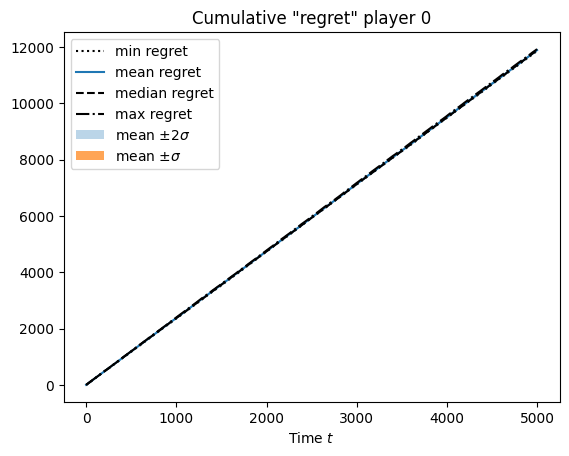

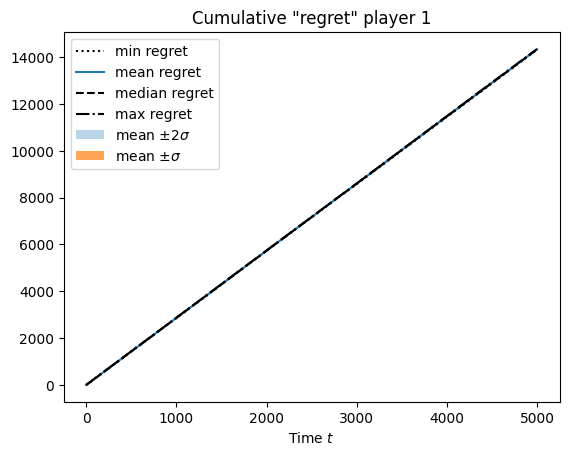

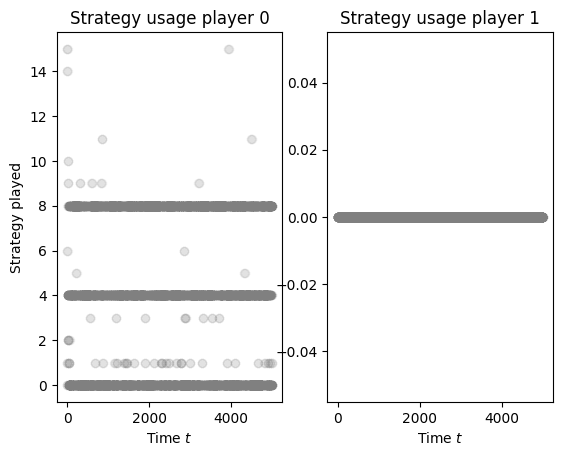

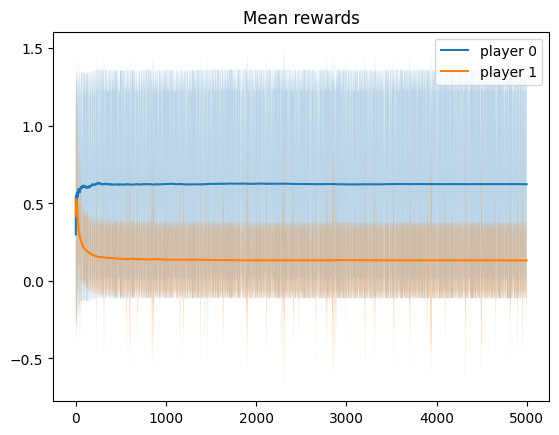

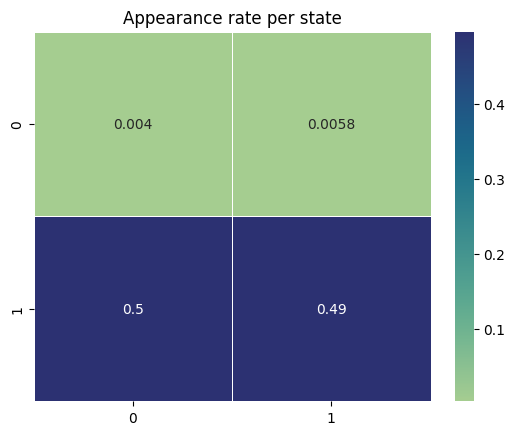

In [30]:
*results_estim, rng_s = simulation_w_estimation_K(game_length=5_000, tau = 0.2, K=10, nb_games=5, eta=lambda t : t, 
                                                  strategy_2=.5*all_strategies[0] + .5*all_strategies[15], initial_state=[0,0])
render_results(*results_estim)

### simulation with asynchronous K

In [31]:
def simulation_w_estimation_async_K(
    strategy_1 = None, 
    strategy_2 = None, 
    nb_games=1, 
    game_length = 1000, 
    initial_state = None,
    rng_state = None,
    eta = lambda t : np.sqrt(t),
    K = (10, 10),
    tau = .9,
    ):
    
    if rng_state is not None:
        np.random.set_state(rng_state)
    else:
        np.random.seed(None)
        rng_state = np.random.get_state()
        
    # all_strategies = get_all_strategies()
    fixed_strat1 = True
    fixed_strat2 = True
    

    #means1 = zeros(4)
    #means2 = zeros(4)
    payout_mean_1 = 0
    payout_mean_2 = 0
    
    strategy_history = np.zeros((nb_games, game_length, 2))
    all_payouts = np.zeros((nb_games, game_length, 2))
    
    for g in range(nb_games):
        print(f"‘{g}/{nb_games}")
        
        if initial_state is None:
            initial_state = np.random.randint(2, size=2)
            
        state = initial_state.copy()
        
        state_frequencies = np.ones((2, 2)) / 4
        action_state = np.zeros((2, 2, 2, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
    
        #state = [rand(1:2), rand(1:2)]
        state_appearances = np.zeros((nb_actions_1, nb_actions_2))
        state_appearances[state[0], state[1]] = 1
        #random_strategy_2 = 0.4 * all_strategies[16, :, :, :] + 0.6 * all_strategies[3, :, :, :]
        # random_strategy_2 = np.ones((2, 2, 2))
        # # [i, j, s] : action1, action2, next_action
        # random_strategy_2[0, 0, 0] = 0
        # random_strategy_2[0, 0, 1] = 1
        # random_strategy_2[0, 1, 0] = 0
        # random_strategy_2[0, 1, 1] = 1
        # random_strategy_2[1, 0, 0] = 0
        # random_strategy_2[1, 0, 1] = 1
        # random_strategy_2[1, 1, 0] = 0
        # random_strategy_2[1, 1, 1] = 1
        if strategy_2 is None:
            idx2 = np.random.randint(len(all_strategies))
            strategy_2 = get_strategy(all_strategies[idx2, :, :, :])
            fixed_strat2 = False
        # print(strategy_2)
        if strategy_1 is None:
            idx1 = np.random.randint(len(all_strategies))
            strategy_1 = get_strategy(all_strategies[idx1, :, :, :])
            fixed_strat1 = False
            
        rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
        rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
        all_states = np.ones((game_length, 2))
        means1 = np.zeros(16)
        means2 = np.zeros(16)
        #means1 = zeros(4)
        #means2 = zeros(4)
        for i in tqdm(range(game_length)):
            action_1 = get_action(strategy_1, state)
            action_2 = get_action(strategy_2, state)
            payouts = get_payouts(action_1, action_2)
            
            all_payouts[g, i, 0] = payouts[0]
            all_payouts[g, i, 1] = payouts[1]
            
            if not fixed_strat1:
                strategy_history[g, i, 0] = idx1
            if not fixed_strat2:
                strategy_history[g, i, 1] = idx2
            # strategy_history[g, i, 0] = idx1
            # strategy_history[g, i, 1] = idx2
            
            action_state[0, state[0], state[1], action_1] += 1
            action_state[1, state[0], state[1], action_2] += 1
            state_appearances[action_1, action_2] += 1
            # state_frequencies = state_appearances / np.sum(state_appearances)
            if i%K[0] == 0:
                if not fixed_strat1:
                    pivot = np.random.rand()
                    strategy_1, means1, idx1 = get_learned_strategy_emp(
                        state_frequencies, 0, rnd_strategy_2_emp, means1, i, pivot, eta)
            if i%K[1] == 0:
                if not fixed_strat2:
                    pivot = np.random.rand()
                    strategy_2, means2, idx2 = get_learned_strategy_emp(
                        state_frequencies, 1, rnd_strategy_1_emp, means2, i, pivot, eta)
                
                rnd_strategy_2_emp = 0.5 * np.ones((2, 2, 2))
                rnd_strategy_1_emp = 0.5 * np.ones((2, 2, 2))
            #strategy_2 = get_strategy(random_strategy_2)
            # full info on the strategies
            #for a=1:2
            #    for b=1:2
            #        rnd_strategy_1_emp[a, b, 1] = (
            #            rnd_strategy_1_emp[a, b, 1]
            #            + (1*(strategy_1[a, b] == 1) - rnd_strategy_1_emp[a,b,1])/(i+1)
            #        )
            #        rnd_strategy_2_emp[a, b, 1] = (
            #            rnd_strategy_2_emp[a, b, 1]
            #            + (1*(strategy_2[a, b] == 1) - rnd_strategy_2_emp[a,b,1])/(i+1)
            #        )
            #    end
            #end
            
            # bandit info
            rnd_strategy_1_emp[state[0], state[1], 0] = (
                (1-tau)*rnd_strategy_1_emp[state[0], state[1], 0]
                +
                tau*(action_1 == 0)
                # action_state[0, state[0], state[1], 0] / np.sum(action_state[0, state[0], state[1]])
                # rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 0) - rnd_strategy_1_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_1_emp[state[0], state[1], 1] = (
                1-rnd_strategy_1_emp[state[0], state[1], 0]
                # + (1*(action_1 == 1) - rnd_strategy_1_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            
            rnd_strategy_2_emp[state[0], state[1], 0] = (
                (1-tau)*rnd_strategy_2_emp[state[0], state[1], 0]
                +
                tau*(action_2 == 0)
                # action_state[1, state[0], state[1], 0] / np.sum(action_state[1, state[0], state[1]])
                # + (1*(action_2 == 0) - rnd_strategy_2_emp[state[0], state[1], 0])/state_frequencies[state[0], state[1]]
            )
            rnd_strategy_2_emp[state[0], state[1], 1] = (
                1 - rnd_strategy_2_emp[state[0], state[1], 0]
                # rnd_strategy_2_emp[state[0], state[1], 1]
                # + (1*(action_2 == 1) - rnd_strategy_2_emp[state[0], state[1], 1])/state_frequencies[state[0], state[1]]
            )
            state = [action_1, action_2]
            all_states[i, 0] = action_1
            all_states[i, 1] = action_2

        # payout_mean_1 = np.cumsum(all_payouts[:, 0]) / np.cumsum(np.ones(game_length))
        # payout_mean_2 = np.cumsum(all_payouts[:, 1]) / np.cumsum(np.ones(game_length))
        # print(strategy_1)
        # print(strategy_2)
        # print(state_appearances)
        # print(means1)
        # array = np.sqrt(game_length) * means1
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        # array = np.sqrt(game_length) * means2
        # array = array - np.max(array)
        # exp_arr = np.exp(array)
        # normed_exp = exp_arr / np.sum(exp_arr)
        # print(normed_exp)
        
    return means1, means2, state_appearances, all_payouts, all_states, strategy_history, rng_state


‘0/1


100%|██████████| 5000/5000 [00:02<00:00, 1670.05it/s]


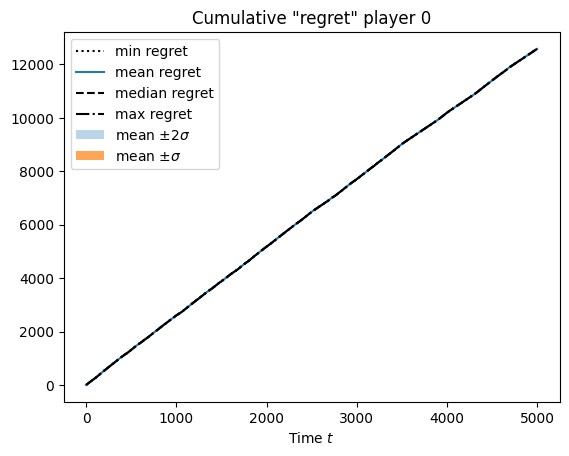

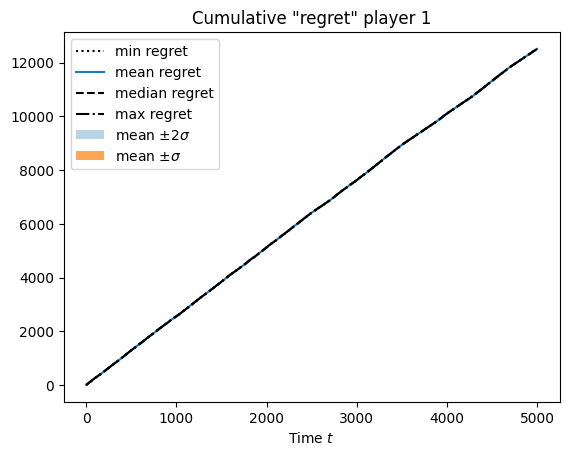

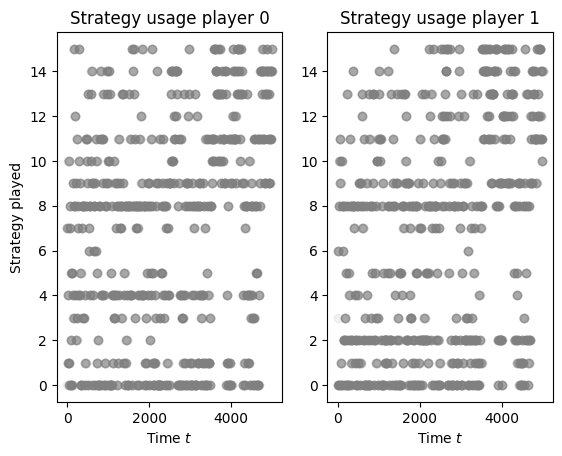

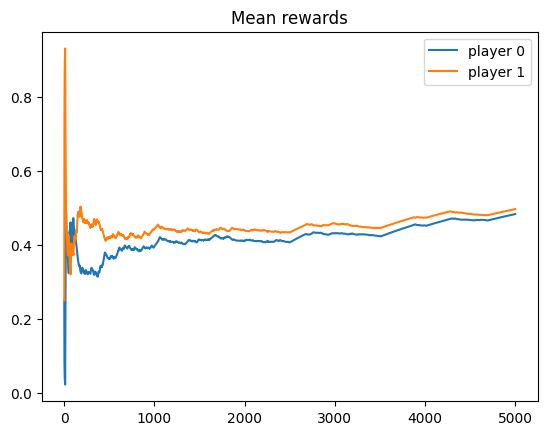

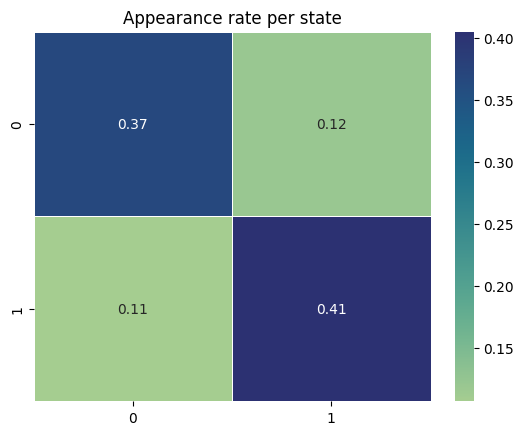

In [32]:
*results_estim2, rng_s = simulation_w_estimation_async_K(game_length=5_000, tau = 0.2, K=[10, 10], nb_games=1)#, eta=lambda t : t)
render_results(*results_estim2)

## Other algorithms

In [33]:
def deterministic_ee(t, means, k):
    #if np.random.random() < 0.05:
    if t == k**2:
        return np.random.randint(0, 2)
    return np.argmin(means)

def tit_for_tat(t, action_1):
    if t == 0:
        return 1
    return action_1[-1]


In [34]:
def simulate(T=1000):
    means_2 = np.zeros(2)
    means_1 = np.zeros(2)
    actions_1 = []
    actions_2 = []
    
    rewards_1 = []
    rewards_2 = []
    
    k = 0
    for t in range(T):
        i = deterministic_ee(t, means_1, k)
        # j = deterministic_ee(t, means_2, k+1)
        j = tit_for_tat(t, actions_1)
        actions_1.append(i)
        actions_2.append(j)
        rewards_1.append(payouts_1[i, j])
        rewards_2.append(payouts_2[i, j])
        if t == k**2:
            k += 1
        means_1[i] = payouts_1[i, j]/(t+1) + means_1[i]*t/(t+1)
        means_2[j] = payouts_2[i, j]/(t+1) + means_2[j]*t/(t+1)
    
    return means_1, means_2, actions_1, actions_2, rewards_1, rewards_2
    

In [35]:
means_1, means_2, actions_1, actions_2, rewards_1, rewards_2 = simulate()

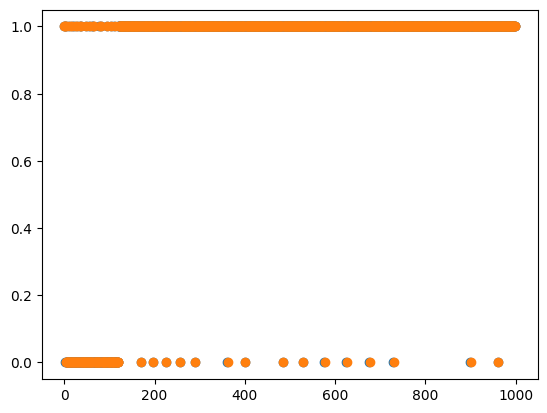

In [36]:
import matplotlib.pyplot as plt
plt.scatter(range(1000), actions_1)
plt.scatter(range(1000), actions_2)

In [37]:
np.count_nonzero(actions_2)

883

In [38]:
means_1

array([0.57658234, 0.30585392])